# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [66]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()

work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   
3       2023               SE              FT            Data Scientist   
4       2023               SE              FT            Data Scientist   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000             EUR          85847                 ES           100   
1   30000             USD          30000                 US           100   
2   25500             USD          25500                 US           100   
3  175000             USD         175000                 CA           100   
4  120000             USD         120000                 CA           100   

  company_location company_size  
0               ES            L  
1               US            S  
2               US            S  
3               CA            M  
4               CA            M

In [67]:
df.shape

(3755, 11)

In [68]:
df.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


Лик в данных может происходить из-за присутствия колонки `salary` - зарплата в другой валюте. 

In [69]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["salary_in_usd", "salary"])
y = df["salary_in_usd"]

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=1.0/9.0, random_state=10)

del df, X_train_full, y_train_full # Удалим ненужные нам переменные

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder

categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.set_output(transform='pandas')
encoded_train = encoder.fit_transform(X_train[categorical_features])
encoded_val = encoder.transform(X_val[categorical_features])
encoded_test = encoder.transform(X_test[categorical_features])

X_train_final = pd.concat([X_train.drop(columns=categorical_features), encoded_train], axis=1)
X_val_final = pd.concat([X_val.drop(columns=categorical_features), encoded_val], axis=1)
X_test_final = pd.concat([X_test.drop(columns=categorical_features), encoded_test], axis=1)

del encoded_train, encoded_val, encoded_test # Удалим ненужные нам переменные

lin_reg = LinearRegression()
lin_reg.fit(X_train_final, y_train)

print('Train MAPE: ', mean_absolute_percentage_error(y_train, lin_reg.predict(X_train_final)))
print('Train RMSE: ', root_mean_squared_error(y_train, lin_reg.predict(X_train_final)))
print('Test MAPE: ', mean_absolute_percentage_error(y_test, lin_reg.predict(X_test_final)))
print('Test RMSE: ', root_mean_squared_error(y_test, lin_reg.predict(X_test_final)))

Train MAPE:  0.30266269675026886
Train RMSE:  44847.11023820339
Test MAPE:  0.34727502052149756
Test RMSE:  47755.86327408617


Результаты получились не очень, зарплаты 47755 на зарплатах в районе от 5000 до 450000 это довольно много, ну а по другой метрике видим, что он ошибается почти на 35 процентов от реальных значений.

In [71]:
# Ради интереса попробуем стандартизировать числовые признаки
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

lin_reg.fit(X_train_scaled, y_train)

print('Train MAPE: ', mean_absolute_percentage_error(y_train, lin_reg.predict(X_train_scaled)))
print('Train RMSE: ', root_mean_squared_error(y_train, lin_reg.predict(X_train_scaled)))
print('Test MAPE: ', mean_absolute_percentage_error(y_test, lin_reg.predict(X_test_scaled)))
print('Test RMSE: ', root_mean_squared_error(y_test, lin_reg.predict(X_test_scaled)))

Train MAPE:  0.302662696750271
Train RMSE:  44847.11023820339
Test MAPE:  0.3552376424641196
Test RMSE:  47837.68617280047


Ну почти ничего не изменилось

In [72]:
del lin_reg, encoder, X_train_scaled, X_test_scaled, scaler

## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [73]:
from xgboost.sklearn import XGBRegressor

params = {
    "n_estimators": 150,
    "max_depth": 3,
    "min_child_weight": 3,
    "colsample_bytree": 0.8,
    "subsample": 0.8,
    "gamma": 0.1,
    "learning_rate": 0.2,
    "seed": 52,
    "nthread": -1
}

In [74]:
# Будем осуществлять подбор гиперпараметров.
# Подбор гипперпараметров начнем с лучшего количества деревьев. (Остальные параметры фиксируем.)
number_of_estimators = [180, 185, 190, 195, 200, 210, 220, 230, 235, 240, 245, 250, 500]
best_n_estimators = None
best_rmse = float('inf')
for n in number_of_estimators:
    xgbr = XGBRegressor(**params)
    xgbr.n_estimators = n
    xgbr.fit(X_train_final, y_train)
    rmse = root_mean_squared_error(y_val, xgbr.predict(X_val_final))
    if (rmse < best_rmse):
        best_rmse = rmse
        best_n_estimators = n

print(f"Best n_estimators: {best_n_estimators}, RMSE: {best_rmse}")
params["n_estimators"] = best_n_estimators

Best n_estimators: 190, RMSE: 47985.66015625


In [75]:
# Теперь переберем вместе максимальную глубину деревьев и минимальное количество объектов в листьях.
max_depths = [1, 3, 5, 7, 10, 15, 20]
min_child_weights = [3, 5, 7, 10, 15, 20, 30]
best_max_depth = None
best_min_child_weight = None
best_rmse = float('inf')
for d in max_depths:
    for w in min_child_weights:
        xgbr = XGBRegressor(**params)
        xgbr.max_depth = d
        xgbr.min_child_weights = w
        xgbr.fit(X_train_final, y_train)
        rmse = root_mean_squared_error(y_val, xgbr.predict(X_val_final))
        if (rmse < best_rmse):
            best_rmse = rmse
            best_max_depth = d
            best_min_child_weight = w

print(f"Best max_depth: {best_max_depth}, best min_child_weight: {best_min_child_weight}, RMSE: {best_rmse}")
params["max_depth"] = best_max_depth
params["min_child_weight"] = best_min_child_weight

Best max_depth: 5, best min_child_weight: 3, RMSE: 47475.94140625


In [76]:
# Теперь переберем вместе долю выборки для каждого дерева и долю признаков.
colsamples_bytree = [0.6, 0.7, 0.8, 0.9]
subsamples = [0.6, 0.7, 0.8, 0.9]
best_colsample_bytree = None
best_subsample = None
best_rmse = float('inf')
for c in colsamples_bytree:
    for s in subsamples:
        xgbr = XGBRegressor(**params)
        xgbr.colsample_bytree = c
        xgbr.subsample = s
        xgbr.fit(X_train_final, y_train)
        rmse = root_mean_squared_error(y_val, xgbr.predict(X_val_final))
        if (rmse < best_rmse):
            best_rmse = rmse
            best_colsample_bytree = c
            best_subsample = s

print(f"Best colsample_bytree: {best_colsample_bytree}, best subsample: {best_subsample}, RMSE: {best_rmse}")
params["colsample_bytree"] = best_colsample_bytree
params["subsample"] = best_subsample

Best colsample_bytree: 0.8, best subsample: 0.8, RMSE: 47475.94140625


In [77]:
import numpy as np

In [78]:
gammas = np.linspace(0.0, 1, 30)
best_gamma = None
best_rmse = float('inf')
for g in gammas:
    xgbr = XGBRegressor(**params)
    xgbr.gamma = g
    xgbr.fit(X_train_final, y_train)
    rmse = root_mean_squared_error(y_val, xgbr.predict(X_val_final))
    if (rmse < best_rmse):
        best_rmse = rmse
        best_gamma = g

print(f"Best gamma: {best_gamma}, RMSE: {best_rmse}")
params["gamma"] = best_gamma

Best gamma: 0.0, RMSE: 47475.94140625


In [79]:
# Попробуем подобрать коэффициент реляризации.
reg_alphas = [30, 40, 45, 50, 55, 60, 70]
best_reg_alpha = None
best_rmse = float('inf')
for a in reg_alphas:
    xgbr = XGBRegressor(**params)
    xgbr.reg_alpha = a
    xgbr.fit(X_train_final, y_train)
    rmse = root_mean_squared_error(y_val, xgbr.predict(X_val_final))
    if (rmse < best_rmse):
        best_rmse = rmse
        best_reg_alpha = a

print(f"Best reg_alpha: {best_reg_alpha}, RMSE: {best_rmse}")
params["reg_alpha"] = best_reg_alpha

Best reg_alpha: 45, RMSE: 47331.51953125


In [80]:
learning_rates = [0.3, 0.2, 0.1, 0.07, 0.05, 0.03, 0.01]
n_estimators = [150, 190, 400, 500, 700, 800, 1000]
best_learning_rate = None
best_n_estimators = None
best_rmse = float('inf')
for lr, n in zip(learning_rates, n_estimators):
    xgbr = XGBRegressor(**params)
    xgbr.learning_rate = lr
    xgbr.n_estimators = n
    xgbr.fit(X_train_final, y_train)
    rmse = root_mean_squared_error(y_val, xgbr.predict(X_val_final))
    if (rmse < best_rmse):
        best_rmse = rmse
        best_learning_rate = lr
        best_n_estimators = n

print(f"Best learning_rate: {best_learning_rate}, new best n_estrmators: {best_n_estimators}, RMSE: {best_rmse}")
params["learning_rate"] = best_learning_rate
params["n_estimators"] = best_n_estimators

Best learning_rate: 0.2, new best n_estrmators: 190, RMSE: 47331.51953125


In [81]:
# Посмотрим какие в итоге у нас гиперпараметры получились
params_xgbr = params
params_xgbr

{'n_estimators': 190,
 'max_depth': 5,
 'min_child_weight': 3,
 'colsample_bytree': 0.8,
 'subsample': 0.8,
 'gamma': np.float64(0.0),
 'learning_rate': 0.2,
 'seed': 52,
 'nthread': -1,
 'reg_alpha': 45}

In [82]:
# Теперь обучим модель с подобранными гиперпараметрами на тренировочной выборке и оценим качество на тестовой выборке
import time # для замера времени обучения
xgbr = XGBRegressor(**params)
train_start_time = time.time()
xgbr.fit(X_train_final, y_train)
train_time_xgbr = time.time() - train_start_time
y_train_pred = xgbr.predict(X_train_final)
mape_xgbr_train = mean_absolute_percentage_error(y_train, y_train_pred)
rmse_xgbr_train = root_mean_squared_error(y_train, y_train_pred)
print('Train MAPE: ', mape_xgbr_train)
print('Train RMSE: ', rmse_xgbr_train)
pred_start_time = time.time()
y_test_pred = xgbr.predict(X_test_final)
pred_time_xgbr = time.time() - pred_start_time
rmse_xgbr_test = root_mean_squared_error(y_test, y_test_pred)
mape_xgbr_test = mean_absolute_percentage_error(y_test, y_test_pred)
print('Test MAPE: ', rmse_xgbr_test)
print('Test RMSE: ', mape_xgbr_test)
print('Time of training: ', train_time_xgbr)
print('Time of prediction: ', pred_time_xgbr)

Train MAPE:  0.2824386656284332
Train RMSE:  42372.40625
Test MAPE:  46072.07421875
Test RMSE:  0.324128121137619
Time of training:  0.31365203857421875
Time of prediction:  0.006934642791748047


Наша модель лучше, чем линейная, но не сильно. Время обучения получилось довольно быстрое и время предсказания тоже.

## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [18]:
from catboost import CatBoostRegressor

params = {
    "iterations": 150,
    "depth": 5,
    "learning_rate": 0.2,
    "random_seed": 52,
    "verbose": False,
    "thread_count": -1
}

In [19]:
# Будем осуществлять подбор гиперпараметров.
# Подбор гипперпараметров начнем с лучшего количества деревьев. (Остальные параметры фиксируем.)
iterations_list = [100, 150, 200, 240, 250, 255, 260, 265, 270, 280, 290, 300]
best_iterations = None
best_rmse = float('inf')
for i in iterations_list:
    cat_boost = CatBoostRegressor(**params)
    cat_boost.set_params(iterations=i)
    cat_boost.fit(X_train_final, y_train)
    rmse = root_mean_squared_error(y_val, cat_boost.predict(X_val_final))
    if (rmse < best_rmse):
        best_rmse = rmse
        best_iterations = i

print(f"Best iterations: {best_iterations}, RMSE: {best_rmse}")
params["iterations"] = best_iterations

Best iterations: 260, RMSE: 47043.006322566325


In [20]:
# Продолжим с глубиной деревьев. (Остальные параметры фиксируем.)
depths = [1, 3, 5, 7, 9, 11]
best_depth = None
best_rmse = float('inf')
for d in depths:
    cat_boost = CatBoostRegressor(**params)
    cat_boost.set_params(depth=d)
    cat_boost.fit(X_train_final, y_train)
    rmse = root_mean_squared_error(y_val, cat_boost.predict(X_val_final))
    if (rmse < best_rmse):
        best_rmse = rmse
        best_depth = d

print(f"Best depth: {best_depth}, RMSE: {best_rmse}")
params["depth"] = best_depth

Best depth: 5, RMSE: 47043.006322566325


In [21]:
learning_rates = [0.2, 0.1, 0.07, 0.05, 0.03, 0.01]
iterations_list = [260, 520, 600, 1000, 1100, 1200]
best_learning_rate = None
best_iterations = None
best_rmse = float('inf')
for lr, it in zip(learning_rates, iterations_list):
    cat_boost = CatBoostRegressor(**params)
    cat_boost.set_params(learning_rate=lr, iterations=it)
    cat_boost.fit(X_train_final, y_train)
    rmse = root_mean_squared_error(y_val, cat_boost.predict(X_val_final))
    if (rmse < best_rmse):
        best_rmse = rmse
        best_learning_rate = lr
        best_iterations = it

print(f"Best learning_rate: {best_learning_rate}, new best iterations: {best_iterations}, RMSE: {best_rmse}")
params["learning_rate"] = best_learning_rate
params["iterations"] = best_iterations

Best learning_rate: 0.2, new best iterations: 260, RMSE: 47043.006322566325


In [22]:
catboost_model = CatBoostRegressor(**params)
train_time_start = time.time()
catboost_model.fit(X_train_final, y_train)
train_time_catboost = time.time() - train_time_start
y_train_pred = catboost_model.predict(X_train_final)
pred_start_time = time.time()
y_test_pred = catboost_model.predict(X_test_final)
pred_time_catboost = time.time() - pred_start_time
mape_catboost_train = mean_absolute_percentage_error(y_train, y_train_pred)
rmse_catboost_train = root_mean_squared_error(y_train, y_train_pred)
mape_catboost_test = mean_absolute_percentage_error(y_test, y_test_pred)
rmse_catboost_test = root_mean_squared_error(y_test, y_test_pred)
print('Train MAPE: ', mape_catboost_train)
print('Train RMSE: ', rmse_catboost_train)
print('Test MAPE: ', mape_catboost_test)
print('Test RMSE: ', rmse_catboost_test)
print('Time of training: ', train_time_catboost)
print('Time of prediction: ', pred_time_catboost)

Train MAPE:  0.29040014343082954
Train RMSE:  42480.97833119843
Test MAPE:  0.3152803140436495
Test RMSE:  45033.9085539782
Time of training:  0.305042028427124
Time of prediction:  0.002685070037841797


Эта модель получилась лучше, да и отработала быстре `XGBRegressor`

Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [23]:
from catboost import Pool

train_pool = Pool(X_train, y_train, cat_features=categorical_features)
val_pool = Pool(X_val, y_val, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

In [24]:
params = {
    "iterations": 150,
    "depth": 5,
    "learning_rate": 0.2,
    "random_seed": 52,
    "verbose": False,
    "thread_count": -1
}

In [25]:
# Будем осуществлять подбор гиперпараметров.
# Подбор гипперпараметров начнем с лучшего количества деревьев. (Остальные параметры фиксируем.)
iterations_list = [100, 105, 110, 115, 120, 150, 200, 250, 300]
best_iterations = None
best_rmse = float('inf')
for i in iterations_list:
    cat_boost = CatBoostRegressor(**params)
    cat_boost.set_params(iterations=i)
    cat_boost.fit(train_pool)
    rmse = root_mean_squared_error(y_val, cat_boost.predict(val_pool))
    if (rmse < best_rmse):
        best_rmse = rmse
        best_iterations = i

print(f"Best iterations: {best_iterations}, RMSE: {best_rmse}")
params["iterations"] = best_iterations

Best iterations: 110, RMSE: 47990.72110286378


In [26]:
# Продолжим с глубиной деревьев. (Остальные параметры фиксируем.)
depths = [1, 3, 5, 7, 9, 11]
best_depth = None
best_rmse = float('inf')
for d in depths:
    cat_boost = CatBoostRegressor(**params)
    cat_boost.set_params(depth=d)
    cat_boost.fit(train_pool)
    rmse = root_mean_squared_error(y_val, cat_boost.predict(val_pool))
    if (rmse < best_rmse):
        best_rmse = rmse
        best_depth = d

print(f"Best depth: {best_depth}, RMSE: {best_rmse}")
params["depth"] = best_depth

Best depth: 7, RMSE: 47727.15503193148


In [27]:
learning_rates = [0.2, 0.1, 0.07, 0.05, 0.03, 0.01, 0.005]
iterations_list = [110, 220, 300, 400, 500, 1000, 1500]
best_learning_rate = None
best_iterations = None
best_rmse = float('inf')
for lr, it in zip(learning_rates, iterations_list):
    cat_boost = CatBoostRegressor(**params)
    cat_boost.set_params(learning_rate=lr, iterations=it)
    cat_boost.fit(train_pool)
    rmse = root_mean_squared_error(y_val, cat_boost.predict(val_pool))
    if (rmse < best_rmse):
        best_rmse = rmse
        best_learning_rate = lr
        best_iterations = it

print(f"Best learning_rate: {best_learning_rate}, new best iterations: {best_iterations}, RMSE: {best_rmse}")
params["learning_rate"] = best_learning_rate
params["iterations"] = best_iterations

Best learning_rate: 0.01, new best iterations: 1000, RMSE: 47676.59459711634


In [28]:
params_catboost = params
params_catboost

{'iterations': 1000,
 'depth': 7,
 'learning_rate': 0.01,
 'random_seed': 52,
 'verbose': False,
 'thread_count': -1}

In [29]:
catboost_model = CatBoostRegressor(**params)
train_time_start = time.time()
catboost_model.fit(train_pool)
train_time_catboost_pool = time.time() - train_time_start
y_train_pred = catboost_model.predict(train_pool)
pred_start_time = time.time()
y_test_pred = catboost_model.predict(test_pool)
pred_time_catboost_pool = time.time() - pred_start_time
mape_catboost_pool_train = mean_absolute_percentage_error(y_train, y_train_pred)
rmse_catboost_pool_train = root_mean_squared_error(y_train, y_train_pred)
mape_catboost_pool_test = mean_absolute_percentage_error(y_test, y_test_pred)
rmse_catboost_pool_test = root_mean_squared_error(y_test, y_test_pred)
print('Train MAPE: ', mape_catboost_pool_train)
print('Train RMSE: ', rmse_catboost_pool_train)
print('Test MAPE: ', mape_catboost_pool_test)
print('Test RMSE: ', rmse_catboost_pool_test)
print('Time of training: ', train_time_catboost_pool)
print('Time of prediction: ', pred_time_catboost_pool)

Train MAPE:  0.35534578350094637
Train RMSE:  45696.255041420045
Test MAPE:  0.3267671162037417
Test RMSE:  45665.77496935269
Time of training:  2.899617910385132
Time of prediction:  0.0011501312255859375


**Ответ:** время обучения увеличилось в 1.5 раза, а вот качество почти не изменилось, хотя видно, что ошибка на тестовой и тренировочной выборке одинакова, то есть модель стала меньше переобучаться.

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [30]:
from lightgbm import LGBMRegressor

params = {
    "n_estimators": 150,
    "min_child_samples": 3,
    "num_leaves": 31,
    "colsample_bytree": 0.8,
    "subsample": 0.8,
    "learning_rate": 0.2,
    "random_state": 52,
    "n_jobs": -1,
    "verbose": -1
}

In [31]:
# Будем осуществлять подбор гиперпараметров.
# Подбор гипперпараметров начнем с лучшего количества деревьев. (Остальные параметры фиксируем.)
number_of_estimators = [40, 45, 50, 55, 60]
best_n_estimators = None
best_rmse = float('inf')
for n in number_of_estimators:
    lgbmr = LGBMRegressor(**params)
    lgbmr.set_params(n_estimators=n)
    lgbmr.fit(X_train_final, y_train)
    rmse = root_mean_squared_error(y_val, lgbmr.predict(X_val_final))
    if (rmse < best_rmse):
        best_rmse = rmse
        best_n_estimators = n

print(f"Best n_estimators: {best_n_estimators}, RMSE: {best_rmse}")
params["n_estimators"] = best_n_estimators

Best n_estimators: 55, RMSE: 47821.24572866601


In [32]:
# Теперь переберем вместе максимальную глубину деревьев и минимальное количество объектов в листьях.
num_leaves = [30, 35, 40, 45, 50, 55, 60]
min_child_samples = [3, 5, 7, 10, 15, 20, 30]
best_num_leaves = None
best_min_child_samples = None
best_rmse = float('inf')
for l in num_leaves:
    for s in min_child_samples:
        lgbmr = LGBMRegressor(**params)
        lgbmr.set_params(num_leaves=l, min_child_samples=s)
        lgbmr.fit(X_train_final, y_train)
        rmse = root_mean_squared_error(y_val, lgbmr.predict(X_val_final))
        if (rmse < best_rmse):
            best_rmse = rmse
            best_num_leaves = l
            best_min_child_samples = s

print(f"Best num_leaves: {best_num_leaves}, best min_child_samples: {best_min_child_samples}, RMSE: {best_rmse}")
params["num_leaves"] = best_num_leaves
params["min_child_samples"] = best_min_child_samples

Best num_leaves: 50, best min_child_samples: 3, RMSE: 47838.82929650127


In [33]:
# Теперь переберем вместе долю выборки для каждого дерева и долю признаков.
colsamples_bytree = [0.6, 0.7, 0.8, 0.9]
subsamples = [0.6, 0.7, 0.8, 0.9]
best_colsample_bytree = None
best_subsample = None
best_rmse = float('inf')
for c in colsamples_bytree:
    for s in subsamples:
        lgbmr = LGBMRegressor(**params)
        lgbmr.set_params(colsample_bytree=c, subsample=s)
        lgbmr.fit(X_train_final, y_train)
        rmse = root_mean_squared_error(y_val, lgbmr.predict(X_val_final))
        if (rmse < best_rmse):
            best_rmse = rmse
            best_colsample_bytree = c
            best_subsample = s

print(f"Best colsample_bytree: {best_colsample_bytree}, best subsample: {best_subsample}, RMSE: {best_rmse}")
params["colsample_bytree"] = best_colsample_bytree
params["subsample"] = best_subsample

Best colsample_bytree: 0.8, best subsample: 0.6, RMSE: 47838.82929650127


In [34]:
# Попробуем подобрать коэффициент реляризации.
reg_alphas = [30, 40, 45, 50, 55, 60, 65, 70]
best_reg_alpha = None
best_rmse = float('inf')
for a in reg_alphas:
    lgbmr = LGBMRegressor(**params)
    lgbmr.set_params(reg_alpha=a)
    lgbmr.fit(X_train_final, y_train)
    rmse = root_mean_squared_error(y_val, lgbmr.predict(X_val_final))
    if (rmse < best_rmse):
        best_rmse = rmse
        best_reg_alpha = a

print(f"Best reg_alpha: {best_reg_alpha}, RMSE: {best_rmse}")
params["reg_alpha"] = best_reg_alpha

Best reg_alpha: 60, RMSE: 48066.36592754821


In [35]:
learning_rates = [0.2, 0.1, 0.07, 0.05, 0.03, 0.01, 0.005, 0.001]
n_estimators = [55, 110, 200, 400, 600, 800, 900, 1000]
best_learning_rate = None
best_n_estimators = None
best_rmse = float('inf')
for lr, n in zip(learning_rates, n_estimators):
    lgbmr = LGBMRegressor(**params)
    lgbmr.set_params(learning_rate=lr, n_estimators=n)
    lgbmr.fit(X_train_final, y_train)
    rmse = root_mean_squared_error(y_val, lgbmr.predict(X_val_final))
    if (rmse < best_rmse):
        best_rmse = rmse
        best_learning_rate = lr
        best_n_estimators = n

print(f"Best learning_rate: {best_learning_rate}, new best n_estrmators: {best_n_estimators}, RMSE: {best_rmse}")
params["learning_rate"] = best_learning_rate
params["n_estimators"] = best_n_estimators

Best learning_rate: 0.005, new best n_estrmators: 900, RMSE: 47655.72331629518


In [36]:
lgbm_params = params
lgbm_params

{'n_estimators': 900,
 'min_child_samples': 3,
 'num_leaves': 50,
 'colsample_bytree': 0.8,
 'subsample': 0.6,
 'learning_rate': 0.005,
 'random_state': 52,
 'n_jobs': -1,
 'verbose': -1,
 'reg_alpha': 60}

In [37]:
# Теперь обучим модель с подобранными гиперпараметрами на тренировочной выборке и оценим качество на тестовой выборке
lgbmr = LGBMRegressor(**params)
train_start_time = time.time()
lgbmr.fit(X_train_final, y_train)
train_time_lgbmr = time.time() - train_start_time
y_train_pred = lgbmr.predict(X_train_final)
mape_lgbmr_train = mean_absolute_percentage_error(y_train, y_train_pred)
rmse_lgbmr_train = root_mean_squared_error(y_train, y_train_pred)
print('Train MAPE: ', mape_lgbmr_train)
print('Train RMSE: ', rmse_lgbmr_train)
pred_start_time = time.time()
y_test_pred = lgbmr.predict(X_test_final)
pred_time_lgbmr = time.time() - pred_start_time
rmse_lgbmr_test = root_mean_squared_error(y_test, y_test_pred)
mape_lgbmr_test = mean_absolute_percentage_error(y_test, y_test_pred)
print('Test MAPE: ', rmse_lgbmr_test)
print('Test RMSE: ', mape_lgbmr_test)
print('Time of training: ', train_time_lgbmr)
print('Time of prediction: ', pred_time_lgbmr)

Train MAPE:  0.28849718076296316
Train RMSE:  42636.27854406154
Test MAPE:  45614.88222000013
Test RMSE:  0.3124137645101117
Time of training:  6.112154006958008
Time of prediction:  0.012536287307739258


## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

In [57]:
# Посмотрим на качество всех моделей
import matplotlib.pyplot as plt
models_name = ('xgboost', 'catboost', 'catboost_pool', 'lightgbm')
rmse = {
    'train': [rmse_xgbr_train, rmse_catboost_train, rmse_catboost_pool_train, rmse_lgbmr_train],
    'test': [rmse_xgbr_test, rmse_catboost_test, rmse_catboost_pool_test, rmse_lgbmr_test]
}

mape = {
    'train': [mape_xgbr_train, mape_catboost_train, mape_catboost_pool_train, mape_lgbmr_train],
    'test': [mape_xgbr_test, mape_catboost_test, mape_catboost_pool_test, mape_lgbmr_test]
}


train_time = [train_time_xgbr, train_time_catboost, train_time_catboost_pool, train_time_lgbmr]
pred_time = [pred_time_xgbr, pred_time_catboost, pred_time_catboost_pool, pred_time_lgbmr]

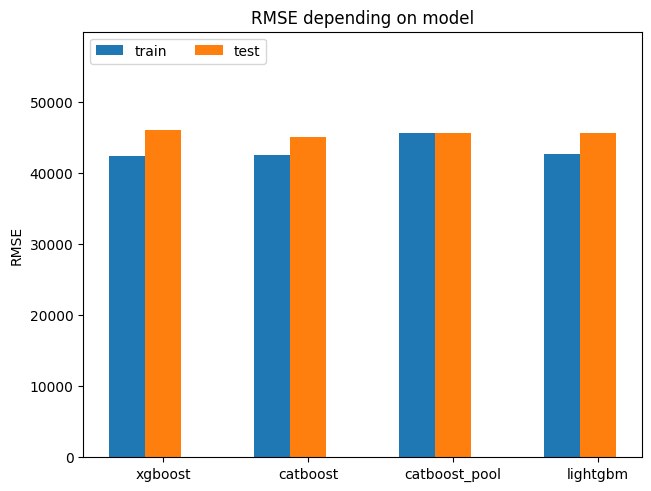

In [58]:
x = np.arange(len(models_name))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in rmse.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

ax.set_ylabel('RMSE')
ax.set_title('RMSE depending on model')
ax.set_xticks(x + width, models_name)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, max(rmse['train'] + rmse['test']) * 1.3)

plt.show()

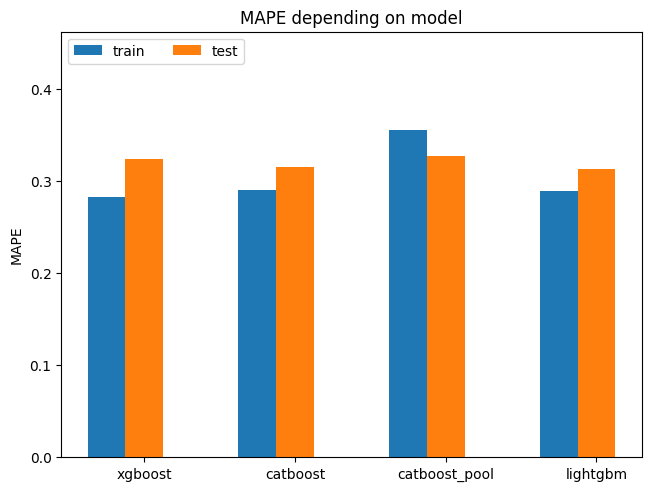

In [59]:
x = np.arange(len(models_name))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in mape.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

ax.set_ylabel('MAPE')
ax.set_title('MAPE depending on model')
ax.set_xticks(x + width, models_name)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, max(mape['train'] + mape['test']) * 1.3)

plt.show()

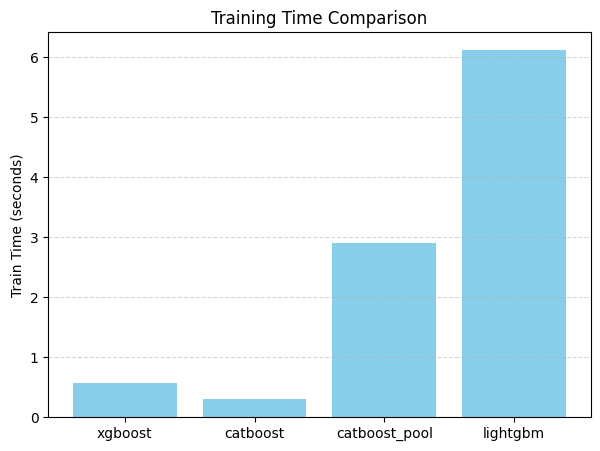

In [61]:
x = range(len(models_name))

plt.figure(figsize=(7, 5))
plt.bar(x, train_time, color='skyblue')
plt.xticks(x, models_name)
plt.ylabel("Train Time (seconds)")
plt.title("Training Time Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

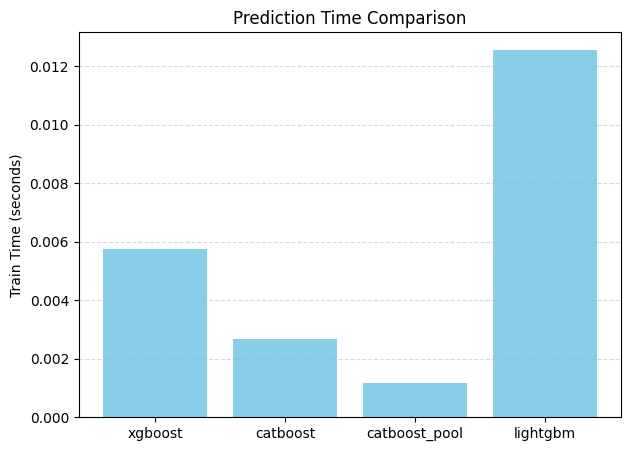

In [62]:
x = range(len(models_name))

plt.figure(figsize=(7, 5))
plt.bar(x, pred_time, color='skyblue')
plt.xticks(x, models_name)
plt.ylabel("Train Time (seconds)")
plt.title("Prediction Time Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [83]:
params_xgbr

{'n_estimators': 190,
 'max_depth': 5,
 'min_child_weight': 3,
 'colsample_bytree': 0.8,
 'subsample': 0.8,
 'gamma': np.float64(0.0),
 'learning_rate': 0.2,
 'seed': 52,
 'nthread': -1,
 'reg_alpha': 45}

In [64]:
params_catboost

{'iterations': 1000,
 'depth': 7,
 'learning_rate': 0.01,
 'random_seed': 52,
 'verbose': False,
 'thread_count': -1}

In [65]:
lgbm_params

{'n_estimators': 900,
 'min_child_samples': 3,
 'num_leaves': 50,
 'colsample_bytree': 0.8,
 'subsample': 0.6,
 'learning_rate': 0.005,
 'random_state': 52,
 'n_jobs': -1,
 'verbose': -1,
 'reg_alpha': 60}

**Ответ:** на всех моделях метрики почти совпадают (в catboost'е без pool'а лучше всего), но только, если использовать pool в catboost видно, что метрики совпадают на тестовом и обучающем наборе, что говорит о меньшем переобучении. На тренировочной выборке ошибка там самая большая, но на тестовой ошибка не уступает другим. По времени обучения catboost выыигрывает у всех, но если взять catboost с pool, то он будет работать медленее, ну это и логично ему надо разобраться еще с этими категориальными данными. Это все равно быстрее чем lightgbm. Все параметры почти совпадают (конечно, те которые одинаковы в разных моделях), только вот в случае lgbm количество деревьев сильно меньше, а lr больше.

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [97]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

user  the beatles  radiohead  deathcab for cutie  coldplay  modest mouse  \
0     0          NaN   0.020417                 NaN       NaN           NaN   
1     1          NaN   0.184962            0.024561       NaN           NaN   
2     2          NaN        NaN            0.028635       NaN           NaN   
3     3          NaN        NaN                 NaN       NaN           NaN   
4     4     0.043529   0.086281            0.034590  0.016712      0.015935   

   sufjan stevens  dylan. bob  red hot clili peppers  pink fluid  ...  \
0             NaN         NaN               0.030496         NaN  ...   
1        0.136341         NaN                    NaN         NaN  ...   
2             NaN    0.024559                    NaN         NaN  ...   
3             NaN         NaN                    NaN         NaN  ...   
4             NaN         NaN                    NaN         NaN  ...   

   municipal waste  townes van zandt  curtis mayfield  jewel  lamb  \
0              NaN               NaN              NaN    NaN   NaN   
1              NaN               NaN              NaN    NaN   NaN   
2              NaN               NaN              NaN    NaN   NaN   
3              NaN               NaN              NaN    NaN   NaN   
4              NaN               NaN              NaN    NaN   NaN   

   michal w. smith  群星  agalloch  meshuggah  yellowcard  
0              NaN NaN       NaN        NaN         NaN  
1              NaN NaN       NaN        NaN         NaN  
2              NaN NaN       NaN        NaN         NaN  
3              NaN NaN       NaN        NaN         NaN  
4              NaN NaN       NaN        NaN         NaN  

[5 rows x 1001 columns]

Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [98]:
ratings = ratings.T

Выкиньте строку под названием `user`.

In [99]:
ratings.drop(index='user', inplace=True)

In [123]:
ratings

0         1         2     3         4         5     \
the beatles         0.000000  0.000000  0.000000   0.0  0.043529  0.000000   
radiohead           0.020417  0.184962  0.000000   0.0  0.086281  0.006322   
deathcab for cutie  0.000000  0.024561  0.028635   0.0  0.034590  0.000000   
coldplay            0.000000  0.000000  0.000000   0.0  0.016712  0.000000   
modest mouse        0.000000  0.000000  0.000000   0.0  0.015935  0.000000   
...                      ...       ...       ...   ...       ...       ...   
michal w. smith     0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
群星                  0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
agalloch            0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
meshuggah           0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
yellowcard          0.000000  0.000000  0.000000   0.0  0.000000  0.000000   

                    6     7         8         9     ...      4990  4991  \
the beatles          0.0   0.0  0.093398  0.017621  ...  0.000000   0.0   
radiohead            0.0   0.0  0.000000  0.019156  ...  0.017735   0.0   
deathcab for cutie   0.0   0.0  0.000000  0.013349  ...  0.121344   0.0   
coldplay             0.0   0.0  0.000000  0.000000  ...  0.217175   0.0   
modest mouse         0.0   0.0  0.000000  0.030437  ...  0.000000   0.0   
...                  ...   ...       ...       ...  ...       ...   ...   
michal w. smith      0.0   0.0  0.000000  0.000000  ...  0.000000   0.0   
群星                   0.0   0.0  0.000000  0.000000  ...  0.000000   0.0   
agalloch             0.0   0.0  0.000000  0.000000  ...  0.000000   0.0   
meshuggah            0.0   0.0  0.000000  0.000000  ...  0.000000   0.0   
yellowcard           0.0   0.0  0.000000  0.000000  ...  0.000000   0.0   

                        4992      4993      4994      4995  4996      4997  \
the beatles         0.121169  0.038168  0.007939  0.017884   0.0  0.076923   
radiohead           0.000000  0.000000  0.011187  0.000000   0.0  0.000000   
deathcab for cutie  0.000000  0.000000  0.000000  0.000000   0.0  0.000000   
coldplay            0.000000  0.000000  0.000000  0.000000   0.0  0.000000   
modest mouse        0.000000  0.000000  0.000000  0.000000   0.0  0.000000   
...                      ...       ...       ...       ...   ...       ...   
michal w. smith     0.000000  0.000000  0.000000  0.000000   0.0  0.000000   
群星                  0.000000  0.000000  0.000000  0.000000   0.0  0.000000   
agalloch            0.000000  0.000000  0.000000  0.000000   0.0  0.000000   
meshuggah           0.000000  0.000000  0.000000  0.000000   0.0  0.000000   
yellowcard          0.000000  0.000000  0.000000  0.000000   0.0  0.000000   

                    4998      4999  
the beatles          0.0  0.000000  
radiohead            0.0  0.000000  
deathcab for cutie   0.0  0.027893  
coldplay             0.0  0.000000  
modest mouse         0.0  0.000000  
...                  ...       ...  
michal w. smith      0.0  0.000000  
群星                   0.0  0.000000  
agalloch             0.0  0.000000  
meshuggah            0.0  0.000000  
yellowcard           0.0  0.000000  

[1000 rows x 5000 columns]

В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [124]:
ratings.fillna(0, inplace=True)
ratings.sample(5)

0         1     2     3     4     5     6     7        8     \
lucero           0.0  0.013033   0.0   0.0   0.0   0.0   0.0   0.0  0.00000   
the cure         0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  0.00000   
lightning bolt   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  0.00000   
the rapture      0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  0.00000   
feist            0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  0.01292   

                    9     ...  4990  4991      4992  4993  4994  4995  4996  \
lucero          0.000000  ...   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   
the cure        0.013616  ...   0.0   0.0  0.009641   0.0   0.0   0.0   0.0   
lightning bolt  0.000000  ...   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   
the rapture     0.000000  ...   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   
feist           0.000000  ...   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   

                4997     4998  4999  
lucero           0.0  0.00000   0.0  
the cure         0.0  0.06464   0.0  
lightning bolt   0.0  0.00000   0.0  
the rapture      0.0  0.00000   0.0  
feist            0.0  0.00000   0.0  

[5 rows x 5000 columns]

## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [125]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=5)
k_means.fit(ratings)
labels = k_means.labels_

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [126]:
unique, counts = np.unique(labels, return_counts=True)
counts

array([  1,   1, 996,   1,   1])

**Ответ:** получившийся реузльтат не полезен для нас, так как он содержит кластеры из 1 исполнителя и в это же время кластер из 982 (почти все). Все объекты в пространстве расположены вероятно равномерно, так как все количество слушателей у разных исполнителей +- одинково, но существует несколько выбросов, либо супер популярные, либо самые не популярные, которые и выделяются в отдельные классы.

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [135]:
single_cluster = unique[counts == 1]
single_artist = []
for idx, cluster in enumerate(labels):
    if cluster in single_cluster:
        single_artist.append(ratings.index[idx])
single_artist

['the beatles', 'dylan. bob', 'divid bowie', 'daphne loves derby']

Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [ ]:
rating_sum = ratings.sum(axis=1).sort_values(ascending=False)
rating_sum

the beatles                          91.844883
radiohead                            59.256073
deathcab for cutie                   32.716688
niИ                                  32.351575
coldplay                             30.151904
                                       ...    
plus-44                               1.075778
finger eleven                         1.062241
jenny lewis with the watson twins     1.054159
jet                                   0.997300
the quitters                          0.901045
Length: 1000, dtype: float64

In [147]:
rating_sum.mean()

np.float64(4.966)

**Ответ:** ну видно, что The Beatles превосходит среднее в примерно 18 раз, поэтому он отдельно и выделяется.

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [ ]:
from sklearn.preprocessing import normalize

# -- YOUR CODE HERE --

Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [ ]:
# -- YOUR CODE HERE --

**Ответ** # -- YOUR ANSWER HERE --

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [ ]:
from scipy.spatial.distance import cosine


centroids = km.cluster_centers_

# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

In [ ]:
import matplotlib.pyplot as plt

# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

In [ ]:
from sklearn.manifold import TSNE

# -- YOUR CODE HERE --

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [ ]:
from sklearn.metrics import silhouette_score

# -- YOUR CODE HERE --

Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

Сделайте t-SNE визуализацию полученной кластеризации.

In [ ]:
# -- YOUR CODE HERE --

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --